In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import deque
from collections import defaultdict
import random
from collections import Counter
from networkx import to_numpy_array

# 1. Data

In [2]:
df_hero_net = pd.read_csv(r"hero-network.csv")
df_edges = pd.read_csv(r"edges.csv")
df_nodes = pd.read_csv(r"nodes.csv")

In [3]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [4]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [5]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [6]:
df_nodes.shape

(19090, 2)

In [7]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

In [8]:
#We remove extra spaces and '/' at the end of the names in the datasets. 

In [8]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [9]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_edges["comic"] = df_edges["comic"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [13]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [14]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [15]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


 We fix the 'spider-man/peter parker' error in the datasets.

In [16]:
df_hero_net = df_hero_net.replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', regex=True)

In [17]:
df_nodes.node = df_nodes.node.replace('SPIDER-MAN/PETER PARKERKER','SPIDER-MAN/PETER PARKER', regex=True)

We check if the error is fixed and if there are other similar errors in the datasets.

At first, we check the hero names.

In [18]:
hero_edges = set(df_edges.hero)
hero_heronet = set(df_hero_net.hero1).union(set(df_hero_net.hero2))
hero_nodes = set(df_nodes.loc[df_nodes.type=='hero']['node'])

print(hero_edges - hero_heronet)
print(hero_heronet - hero_edges)

{'RED WOLF II', 'SEA LEOPARD', 'CALLAHAN, DANNY', 'FENRIS', 'DEATHCHARGE', 'KULL', 'SHARKSKIN', 'BERSERKER II', 'GIURESCU, RADU', 'BLARE', 'LUNATIK II', 'RANDAK', 'CLUMSY FOULUP', 'MARVEL BOY II/MARTIN', 'RUNE', 'ZANTOR', 'JOHNSON, LYNDON BAIN', 'GERVASE, LADY ALYSSA'}
set()


In [20]:
print(hero_edges - hero_nodes)
print(hero_nodes - hero_edges)

{'BISHOP ', 'ROGUE '}
{'ROGUE', 'BISHOP'}


In [21]:
print(hero_nodes - hero_heronet)
print(hero_heronet - hero_nodes)

{'SEA LEOPARD', 'KULL', 'BISHOP', 'LUNATIK II', 'CLUMSY FOULUP', 'ZANTOR', 'RUNE', 'BLARE', 'CALLAHAN, DANNY', 'DEATHCHARGE', 'RANDAK', 'MARVEL BOY II/MARTIN', 'JOHNSON, LYNDON BAIN', 'GERVASE, LADY ALYSSA', 'FENRIS', 'GIURESCU, RADU', 'SHARKSKIN', 'RED WOLF II', 'BERSERKER II', 'ROGUE'}
{'BISHOP ', 'ROGUE '}


Then, we check the comic names.

In [22]:
comic_edges = set(df_edges.comic)
comic_nodes = set(df_nodes.loc[df_nodes.type=='comic']['node'])

In [23]:
print(comic_edges-comic_nodes)
print(comic_nodes-comic_edges)

set()
set()


We notice that some hero names are the same as comic names. We therefore decide to add word 'comic' at the end to the comic names equal to those of the heroes, in order to avoid problems in the creation and management of graphs.

In [24]:
equals = hero_edges.intersection(comic_edges)
equals

{'BLADE', 'REBEL', 'SABRE'}

In [25]:
hero_nodes.intersection(comic_nodes)

{'BLADE', 'REBEL', 'SABRE'}

In [26]:
for i in equals:
    df_edges.comic = df_edges.comic.replace(i, i+' comic', regex=True)


## 1.2 First graph

In [27]:
G1 = nx.MultiGraph()

In [28]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [29]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [30]:
list(G1.edges())[:10]

[('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL")]

In [31]:
dicOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfOccurances:
            dicOfOccurances[(h1,h2)] += 1
        else:
            dicOfOccurances[(h1,h2)] = 1


In [32]:
G1_weighted = nx.MultiGraph()

In [33]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[edge], 3))
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[(edge[1], edge[0])],3))


In [34]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 2), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 3), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 4), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 5), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 6), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 0), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 1), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 2), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 3), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 4)

In [35]:
G1_weighted['LITTLE, ABNER']['PRINCESS ZANDA']

AtlasView({0: {'weight': 0.2}, 1: {'weight': 0.2}, 2: {'weight': 0.2}, 3: {'weight': 0.2}, 4: {'weight': 0.2}, 5: {'weight': 0.2}, 6: {'weight': 0.2}, 7: {'weight': 0.2}})

In [36]:
G1_weighted_graph = nx.Graph(G1_weighted)
G1_weighted_graph['LITTLE, ABNER']['PRINCESS ZANDA']

{'weight': 0.2}

In [37]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted_graph, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)
(('LITTLE, ABNER', 'JACOBS, GLENDA'), 1.0)
(('LITTLE, ABNER', 'WAR MACHINE II/PARNE'), 1.0)
(('LITTLE, ABNER', 'SAPPER'), 1.0)
(('LITTLE, ABNER', 'HOGAN, VIRGINIA PEPP'), 1.0)
(('LITTLE, ABNER', 'BINARY/CAROL DANVERS'), 1.0)
(('LITTLE, ABNER', 'FIN FANG FOOM/MIDGAR'), 1.0)
(('LITTLE, ABNER', 'MANN, DR. J. VERNON'), 0.5)
(('LITTLE, ABNER', 'THOR/DR. DONALD BLAK'), 1.0)
(('LITTLE, ABNER', 'TEMPEST II/NICOLETTE'), 1.0)
(('LITTLE, ABNER', 'JARVIS, EDWIN'), 1.0)


In [38]:
dicOfWeights = {}
for edge in G1_weighted_graph.edges():
    dicOfWeights[edge] = G1_weighted_graph.get_edge_data(edge[0], edge[1])['weight']


In [39]:
print('Number of nodes of the first graph: ' + str(len(G1_weighted_graph.nodes())))
print('Number of edges of the first graph: ' +  str(len(G1_weighted_graph.edges())))

Number of nodes of the first graph: 6421
Number of edges of the first graph: 167100


## 1.3 Second graph

In [40]:
attributes = {}
for elem in df_edges['hero']:
    attributes[elem] = {'type' : 'hero' } 
for elem in df_edges['comic']:
    attributes[elem] = {'type' : 'comic' } 

print('Number of elements in attributes list: ' + str(len(attributes)))

Number of elements in attributes list: 19090


In [41]:
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)
print('Number of nodes of the second graph: ' + str(len(G2.nodes())))
print('Number of edges of the second graph: ' +  str(len(G2.edges())))

Number of nodes of the second graph: 19090
Number of edges of the second graph: 96104


In [81]:
nodes, types = zip(*nx.get_node_attributes(G2_topN, 'type').items())
for i in range(10):
    print(nodes[i], types[i])

A 140 comic
C&D3 12 comic
IMSVS 1/3 comic
M/SHSW 11 comic
M/SHSW 8 comic
TTA 82/2 comic
ASM 270 comic
S-M 60 comic
A 78 comic
XF 41 comic


In [43]:
def top_N(df,N):
    return df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)

In [49]:
def create_G1_topN(N, df):
    G_topN = G1_weighted_graph.copy()
    most_popular_heros = df.groupby("hero", group_keys=False).count().sort_values(by='comic', ascending = False).head(N)
    notInTopN = set(G1_weighted_graph.nodes()) - set(most_popular_heros.index)
    G_topN.remove_nodes_from(notInTopN)
    return G_topN

In [45]:
def create_G2_topN(N, df):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count").sort_values(by = 'count',ascending=False).head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G2.subgraph(new_nodes)
    return G_top_N

In [48]:
G1_topN = create_G1_topN(50, df_edges)
len(G1_topN.edges())

1194

In [46]:
G2_topN = create_G2_topN(50, df_edges)
# check if the number of nodes is 50
len(G2_topN.nodes())
# change the number of nodes of create_G2_topN(50, df_edges) to 50


9286

# Functionality 1

In [50]:
from collections import Counter


In [51]:
def degree_distG(G):
    degree_G = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degree_G)
    return degree_counts


In [70]:
def hubsG(G):
    degreeG1 = [G.degree(n) for n in G.nodes()]
    ex_nodes = [n for n in G.nodes() if G.degree(n) > np.percentile(degreeG1,95)]
    return(ex_nodes)

In [71]:
def hubs(G):
    degreeG2 = [G.degree(n) for n in G.nodes()]
    ex_nodes = [n for n in G.nodes() if G.degree(n) > np.percentile(degreeG2,95) and G.nodes[n].get('type', '') == 'comic']
    return(ex_nodes)

In [54]:
def density_G(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    return 2*m/(n*(n-1))

In [55]:
def functionality_1(G,G_type,N):
    G = G.copy()
    if G_type == 1:
        G = create_G1_topN(N,df_edges)
        
        n_nodesG1 = int(G.number_of_nodes())
        degree_G1 = G.degree()
        
        sorted_degree_G1 = sorted(degree_G1, key=lambda x: x[1], reverse=True)
    
        densityG1 = len(G.edges())/(n_nodesG1*(n_nodesG1-1)/2)
        
        degree_sequence = [deg for i, deg in G.degree()]
        avg_degreeG1 = sum(degree_sequence) / len(degree_sequence)
        
        type_graphG1 = ""    
        if density_G(G) >= 0.5:
            type_graphG1 = "DENSE"
        else:
            type_graphG1 = "SPARSE"
            
    
        print("Number of nodes of G1: ", n_nodesG1)
        print("sorted collaborations of each node:", sorted_degree_G1)
        print("The density of G1 is:", densityG1)
        print("the degree distribution of G1 is", degree_distG(G))
        print("Average degree of G1: ", avg_degreeG1)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G)), 
        "\n", sorted(hubsG(G), key=lambda x: G.degree(x), reverse=True))
        print("The type of G1 is: ", type_graphG1)
    G = G.copy()
    if G_type == 2:
        G = create_G2_topN(N,df_edges)
        nodes, types = zip(*nx.get_node_attributes(G, 'type').items())
        count_hero = 0
        count_comic = 0
        for elements in types:
            if elements == 'hero':
                count_hero += 1
            elif elements == 'comic':
                count_comic += 1
        degree_G = G.degree()
        
        hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
    
        densityG2 = len(G.edges())/(count_hero*(count_hero-1)/2)
        
        degree_sequence = [deg for i, deg in G.degree()]
        avg_degreeG2 = sum(degree_sequence) / len(degree_sequence)
        
        type_graphG2 = ""    
        if density_G(G) >= 0.5:
            type_graphG2 = "DENSE"
        else:
            type_graphG2 = "SPARSE"
    
    
        print("Number of nodes of G2: ", count_hero, count_comic)
        print( "the number of heroes that have appeared in each comic of G2:" , "\n", hero_appeard)
        print("The density of G2 is:", densityG2)
        print("the distribution of G2 is", degree_distG(G))
        print("Average degree of G2: ", avg_degreeG2)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G)),
         "\n", sorted(hubs(G), key=lambda x: G.degree(x), reverse=True))    
        print("The type of G2 is: ", type_graphG2)
    return


In [76]:
functionality_1(G1_topN,1,50)
# considering the top 50 nodes of G1:
# the density is 0.97, the value si high, so the graph is dense
# the average degree is 47.76, that means generally a node has 47.76 connections with other nodes
# in this case we don't have hubs, because don't have nodes with a degree more extensive than the 95th percentile of the degree distribution
# the type of graph is dense, so we have a lot of connections between nodes, otherwirs if that was "SPARSE" we would have a lot of nodes with a lower degree

Number of nodes of G1:  50
sorted collaborations of each node: [('IRON MAN/TONY STARK', 49), ('THOR/DR. DONALD BLAK', 49), ('CYCLOPS/SCOTT SUMMER', 49), ('BEAST/HENRY &HANK& P', 49), ('HULK/DR. ROBERT BRUC', 49), ('INVISIBLE WOMAN/SUE', 49), ('THING/BENJAMIN J. GR', 49), ('SCARLET WITCH/WANDA', 49), ('CAPTAIN AMERICA', 49), ('WONDER MAN/SIMON WIL', 49), ('WOLVERINE/LOGAN', 49), ('SHE-HULK/JENNIFER WA', 49), ('SILVER SURFER/NORRIN', 49), ('VISION', 49), ('MARVEL GIRL/JEAN GRE', 49), ('STORM/ORORO MUNROE S', 49), ('MR. FANTASTIC/REED R', 49), ('ANGEL/WARREN KENNETH', 49), ('ICEMAN/ROBERT BOBBY', 49), ('WASP/JANET VAN DYNE', 49), ('ANT-MAN/DR. HENRY J.', 49), ('BLACK WIDOW/NATASHA', 49), ('SPIDER-MAN/PETER PARKER', 49), ('SUB-MARINER/NAMOR MA', 49), ('HUMAN TORCH/JOHNNY S', 49), ('COLOSSUS II/PETER RA', 49), ('DR. STRANGE/STEPHEN', 49), ("BLACK PANTHER/T'CHAL", 48), ('JARVIS, EDWIN', 48), ('HAWK', 48), ('HERCULES [GREEK GOD]', 48), ('FURY, COL. NICHOLAS', 48), ('JONES, RICHARD MILHO', 48)

In [56]:
functionality_1(G2_topN,2,50)

Number of nodes of G2:  50 9236
the number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]
The density of G2 is: 22.623673469387754
the distribution of G2 is Counter({1: 3598, 2: 2022, 3: 984, 4: 751, 5: 632, 6: 385, 7: 243, 8: 172, 9: 125, 10: 75, 11: 70, 12: 40, 13: 25, 18: 21, 14: 20, 15: 14, 21: 10, 17: 9, 16: 9, 19: 7, 24: 6, 20: 3, 22: 3, 25: 3, 30: 2, 33: 2, 29: 2, 270: 2, 444: 2, 605: 1, 585: 1, 631: 1, 622: 1, 603: 1, 384: 1, 854: 1, 1577: 1, 320: 1, 32: 1, 27: 1, 1150: 1, 342: 1, 452: 1, 523: 1, 318: 1, 581: 1, 390: 1, 956: 1, 635: 1, 329: 1, 762: 1, 835: 1, 427: 1, 380: 1, 577: 1, 23: 1, 530: 1, 279: 1, 819: 1, 307: 1, 471: 1, 399: 1, 619: 1, 377: 1, 3

# Functionality 2 - Find top superheroes!

In [57]:
def fun_betweenness_centrality(G, normalized=True):
    betweenness = {}
    for s in G:
        for t in G:
            if s != t:
                # Calcolo i percorsi minimi tra s e t utilizzando l'algoritmo BFS
                path = nx.shortest_path(G, s, t)
                if path is not None:
                    for v in path:
                        betweenness.setdefault(v, 0)
                        betweenness[v] += 1
    # Normalizza i valori della betweenness
    n = len(G)
    for v in betweenness:
        betweenness[v] /= (n-1)*(n-2)
    return betweenness

In [139]:
def fun_betweenness_centrality(G, normalized=True):
    betweenness = defaultdict(float)
    for s in G:
        for t in G:
            if s != t:
                # Calcolo i percorsi minimi tra s e t utilizzando l'algoritmo di NetworkX shortest_path
                path = nx.shortest_path(G, s, t)
                if path is not None:
                    for v in path:
                        betweenness[v] += 1
    # Normalizza i valori della betweenness
    n = len(G)
    for v in betweenness:
        betweenness[v] /= (n-1)*(n-2)
    return betweenness


In [173]:
def fun_degree_centrality(G, nodo):
    if G.has_node(nodo):
        num_neighbors = len(list(G.neighbors(nodo)))
        fun_degree_centrality = num_neighbors / (len(G) - 1)
        return fun_degree_centrality
    else:
        return 0

In [215]:
def fun_pagerank(G, d=0.85, eps=1e-8):
  # Inizializza il vettore di PageRank
  N = len(G)
  pagerank = {page: 1/N for page in G}
  
  # Itera fino a quando il vettore di PageRank non convergerà
  while True:
    new_pagerank = {page: (1 - d) / N for page in G}
    
    # Aggiungi la contribuzione di ogni pagina
    for page in G.nodes():
      for link in G[page]:
        new_pagerank[link] += d * pagerank[page] / len(G[page])
    
    # Verifica se il vettore di PageRank è cambiato di molto
    max_diff = max(abs(pagerank[page] - new_pagerank[page]) for page in G)
    if max_diff < eps:
      break
    
    pagerank = new_pagerank
  
  return pagerank




In [237]:
def fun_closeness_centrality(G, node):
  # Inizializza una coda e un dizionario per tenere traccia della distanza di ogni nodo dal nodo in questione
  queue = deque([node])
  distances = {node: 0}

  # Esegue la ricerca in larghezza a partire dal nodo in questione
  while queue:
    current_node = queue.popleft()
    for neighbor in G[current_node]:
      if neighbor not in distances:
        distances[neighbor] = distances[current_node] + 1
        queue.append(neighbor)

  # Calcola la somma delle distanze di tutti i nodi dal nodo in questione
  total_distance = sum(distances.values())
  # Calcola la centralità di prossimità come il numero di nodi del grafo diviso dalla somma delle distanze
  closeness_centrality = len(G) / total_distance
  return closeness_centrality

In [ ]:
def functionality_2(G,node,metric,N):
    for nodo in G.nodes() and N:
        print("the node is: ", nodo)
        if G == G1_topN:
        #if metric == "betweenness":
            #print(" the betweenness centrality of G1: ", fun_betweenness_centrality(G, nodo))
            if metric == "degree":
                print(" the degree centrality of G1: ", fun_degree_centrality(G, nodo))
            elif metric == "pagerank":
                print(" the pagerank centrality of G1: ", fun_pagerank_centrality(G))
            elif metric == "closeness":
            #print(" the closeness centrality of G1: ", fun_closeness_centrality(G, top_N))
        else:
            #print(" the betweenness centrality of G2: ", fun_betweenness_centrality(G))
            if metric == "degree":
                print(" the degree centrality of G2: ", fun_degree_centrality(G, nodo))
            elif metric == "pagerank":
                print(" the pagerank centrality of G2: ", fun_pagerank_centrality(G))
            elif metric == "closeness":
            #print(" the closeness centrality of G2: ", fun_closeness_centrality(G, topN_heroes))
    return


In [59]:
def functionality_2(G, node, metric, N):
    if G == G1_topN:
        graph_name = "G1_topN"
    elif G == G2_topN:
        graph_name = "G2_topN"
    else:
        pass

    for nodo, n in zip(G.nodes(), range(N)):
        print("the node is: ", nodo)
        pagerank = nx.pagerank(G)
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        degree = nx.degree_centrality(G)
        if metric == "betweenness":
            print(" the betweenness centrality of {}: ".format(graph_name), betweenness)
        elif metric == "degree":
            print(" the degree centrality of {}: ".format(graph_name), degree)
        elif metric == "pagerank":
            print(" the pagerank centrality of {}: ".format(graph_name), pagerank)
        elif metric == "closeness":
            print(" the closeness centrality of {}: ".format(graph_name), closeness)
    return


In [60]:
functionality_2(G1_topN, 1,"betweenness", 10)

the node is:  BLACK PANTHER/T'CHAL
 the betweenness centrality of G1_topN:  {"BLACK PANTHER/T'CHAL": 0.0005128357462588104, 'IRON MAN/TONY STARK': 0.0006354454021315732, 'THOR/DR. DONALD BLAK': 0.0006354454021315732, 'JARVIS, EDWIN': 0.0005749099600522091, 'CYCLOPS/SCOTT SUMMER': 0.0006354454021315732, 'BEAST/HENRY &HANK& P': 0.0006354454021315732, 'HULK/DR. ROBERT BRUC': 0.0006354454021315732, 'PUNISHER II/FRANK CA': 0.00019864358283836657, 'INVISIBLE WOMAN/SUE': 0.0006354454021315732, 'THING/BENJAMIN J. GR': 0.0006354454021315732, 'SCARLET WITCH/WANDA': 0.0006354454021315732, 'CAPTAIN AMERICA': 0.0006354454021315732, 'WONDER MAN/SIMON WIL': 0.0006354454021315732, 'WOLVERINE/LOGAN': 0.0006354454021315732, 'SHE-HULK/JENNIFER WA': 0.0006354454021315732, 'SILVER SURFER/NORRIN': 0.0006354454021315732, 'VISION': 0.0006354454021315732, 'MARVEL GIRL/JEAN GRE': 0.0006354454021315732, 'STORM/ORORO MUNROE S': 0.0006354454021315732, 'MR. FANTASTIC/REED R': 0.0006354454021315732, 'ANGEL/WARREN KE

In [61]:
functionality_2(G1_topN, 1,"degree", 10)

the node is:  BLACK PANTHER/T'CHAL
 the degree centrality of G1_topN:  {"BLACK PANTHER/T'CHAL": 0.9795918367346939, 'IRON MAN/TONY STARK': 0.9999999999999999, 'THOR/DR. DONALD BLAK': 0.9999999999999999, 'JARVIS, EDWIN': 0.9795918367346939, 'CYCLOPS/SCOTT SUMMER': 0.9999999999999999, 'BEAST/HENRY &HANK& P': 0.9999999999999999, 'HULK/DR. ROBERT BRUC': 0.9999999999999999, 'PUNISHER II/FRANK CA': 0.836734693877551, 'INVISIBLE WOMAN/SUE': 0.9999999999999999, 'THING/BENJAMIN J. GR': 0.9999999999999999, 'SCARLET WITCH/WANDA': 0.9999999999999999, 'CAPTAIN AMERICA': 0.9999999999999999, 'WONDER MAN/SIMON WIL': 0.9999999999999999, 'WOLVERINE/LOGAN': 0.9999999999999999, 'SHE-HULK/JENNIFER WA': 0.9999999999999999, 'SILVER SURFER/NORRIN': 0.9999999999999999, 'VISION': 0.9999999999999999, 'MARVEL GIRL/JEAN GRE': 0.9999999999999999, 'STORM/ORORO MUNROE S': 0.9999999999999999, 'MR. FANTASTIC/REED R': 0.9999999999999999, 'ANGEL/WARREN KENNETH': 0.9999999999999999, 'ICEMAN/ROBERT BOBBY': 0.99999999999999

In [62]:
functionality_2(G2_topN, 1,"degree", 10)

the node is:  A 140


KeyboardInterrupt: 

In [ ]:
functionality_2(G1_topN, 1,"closeness", 10)

In [ ]:
functionality_2(G2_topN, 1,"degree", 10)

In [ ]:
#comparing the results of the different centrality measures

## Functionality 3

In [54]:
def top_N(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G.subgraph(new_nodes)
    return G_top_N

In [55]:
def shortest_path_two_nodes(node_1, node_2, G, list_nodes):
    if not nx.has_path(G,node_1,node_2):
        return []
    new_list = set(list_nodes)
    new_list.remove(node_1)
    new_list.remove(node_2)
    nodes = [i for i in G.nodes if i not in new_list]
    return list(nx.shortest_path(G.subgraph(nodes), source=node_1, target=node_2, weight=None))

In [56]:
def functionality_3(G2, N, h_1, h_n, h):
    if N:
        N = int(N)
        G2 = top_N(df_edges,N,G2)
    att = nx.get_node_attributes(G2, "type")
    if not nx.is_connected(G2):
        result = 'There is not such path because the graph is not connected'
        return result
    if h_1  not in list(G2.nodes) or h_n not in list(G2.nodes):
        result = 'There is not such path'
        return result
    shortest_path = np.array([h_1])
    s = h_1
    for t in h:
        app = shortest_path_two_nodes(s,t,G2,[h_1]+h+[h_n])
        if app == []:
            return [], G2
        #app = list(nx.shortest_path(G2, source=s, target=t, weight=None))
        s = t
        app = np.array(app)
        shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    app = list(nx.shortest_path(G2, source=t, target=h_n, weight=None))
    app = np.array(app)
    shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    
    return shortest_path, G2

# Functionality 4

In [57]:
def search_shortest_path(G, source, target):
    try:
        return nx.shortest_path(G, source, target, weight='weight', method='dijkstra')
    except: 
        return 0

In [58]:
def functionality_4(G, heroA, heroB, N, df):
    count = 0
    G_final = create_G_topN(G, N, df)

    while search_shortest_path(G_final, heroA, heroB) != 0:
        shortest_path = search_shortest_path(G_final, heroA, heroB)
        dic = {}
        for i in range(len(shortest_path)-1):
            weight = G.get_edge_data(shortest_path[i], shortest_path[i+1])['weight']
            dic[(shortest_path[i],shortest_path[i+1])] = weight
        
        dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))       
        G_final.remove_edge(list(dic.keys())[0][0], list(dic.keys())[0][1])
        count+=1
    
    colors = ['red' if node == heroA or node == heroB else 'blue' 
                for node in G_final.nodes()]
                
    return G_final, count, colors

# Functionality 5

In [59]:
def top_N_1(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    G_top_N = G.subgraph(nodes)
    return G_top_N

In [60]:
def edges_to_remove(G):
    
    num_components = nx.number_connected_components(G)
    
    edges_to_remove = 0
    while True:
        if num_components > 1:
                break
        G_dict = {}
        G_dict = nx.edge_betweenness_centrality(G)
        max_EBC = max(G_dict.values())
        edges = []
        for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
            if value < max_EBC:
                break
            edges.append(key)
        edges_to_remove += len(edge)
        for e in edges:
            G.remove_edge(e[0], e[1])
        components = nx.connected_components(G)
        num_components = nx.number_connected_components(G)
    return edges_to_remove, G

In [61]:
def functionality_5(G1,N, Hero_1, Hero_2):
    G_top_N = top_N_1(df_edges,N,G1)
    G = nx.Graph(G_top_N)
    
    hero_1_2_together = False
    number_of_edges, G = edges_to_remove(G)
    comunities = []
    for comunity in nx.connected_components(G):
        comunities.append(list(comunity))
        if Hero_1 in comunity and Hero_2 in comunity:
            hero_1_2_together = True
    

    return number_of_edges, G, comunities, hero_1_2_together, G_top_N

# 3. Frontend Implementationc

## Visualization 1 - Visualize some features of the network

In [63]:
hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
print( "the number of heroes that have appeared in each comic of G2:" , "\n", hero_appeard)

the number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]


In [86]:
def visualization_1(G,G_type,N):
    G = G.copy()
    if G_type == 1:
        G = create_G1_topN(N,df_edges)
        
        n_nodesG1 = int(G.number_of_nodes())
        degree_G1 = G.degree()
        
        sorted_degree_G1 = sorted(degree_G1, key=lambda x: x[1], reverse=True)
    
        densityG1 = len(G.edges())/(n_nodesG1*(n_nodesG1-1)/2)
        
        degree_sequence = [deg for i, deg in G.degree()]
        avg_degreeG1 = sum(degree_sequence) / len(degree_sequence)
        
        type_graphG1 = ""    
        if density_G(G) >= 0.5:
            type_graphG1 = "DENSE"
        else:
            type_graphG1 = "SPARSE"
            
    
        print("Number of nodes of G1: ", n_nodesG1)
        print("sorted collaborations of each node:", sorted_degree_G1)
        print("The density of G1 is:", densityG1)
        print(degree_distG(G))
        print("Average degree of G1: ", avg_degreeG1)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubsG(G)), 
        "\n", sorted(hubsG(G), key=lambda x: G.degree(x), reverse=True))
        print("The type of G1 is: ", type_graphG1)
    

        general_info_G1 = {
                "Number of nodes": n_nodesG1,
                "Density": densityG1,
                "Average degree": avg_degreeG1,
                "netowrk type" : type_graphG1,
                }
        # general info of G1
        general_info_G1= pd.DataFrame(general_info_G1, index=[0])
        print("General info of G1","/n", general_info_G1)
        # hubs of G1
        df_hubs = pd.DataFrame(hubsG(G), columns=['Hubs'])
        df_hubs
        print("hubs tabe of G1", df_hubs)
        # number of collaborations of each hero
        plt.figure(figsize=(10,10))
        plt.bar(*zip(*sorted_degree_G1))
        plt.title("Number of collaborations of each hero in descending order of G1")
        plt.xlabel("Hero")
        plt.ylabel("Number of collaborations")
        plt.show()

        # degree distribution of the network
        plt.figure(figsize=(10,5))
        plt.hist(degree_distG(G), bins=50)
        plt.xlabel('degree')
        plt.ylabel('number of nodes')
        plt.show()

    if G_type == 2:
        
        
        count_hero = 0
        count_comic = 0
        for elements in types:
            if elements == 'hero':
                count_hero += 1
            elif elements == 'comic':
                count_comic += 1
        degree_G = G.degree()
        
        hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
    
        densityG2 = len(G.edges())/(count_hero*(count_hero-1)/2)
        
        degree_sequence = [deg for i, deg in G.degree()]
        avg_degreeG2 = sum(degree_sequence) / len(degree_sequence)
        
        type_graphG2 = ""    
        if density_G(G) >= 0.5:
            type_graphG2 = "DENSE"
        else:
            type_graphG2 = "SPARSE"
    
    
        print("Number of nodes of G2: ", count_hero, count_comic)
        print( "the number of heroes that have appeared in each comic of G2:" , "\n", hero_appeard)
        print("The density of G2 is:", densityG2)
        print(degree_distG(G))
        print("Average degree of G2: ", avg_degreeG2)
        print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G)),
         "\n", sorted(hubs(G), key=lambda x: G.degree(x), reverse=True))    
        print("The type of G2 is: ", type_graphG2)
       
        general_info_G2 = {
                "Number of nodes": count_hero and count_comic,
                "Density": densityG2,
                "Average degree": avg_degreeG2,
                "netowrk type" : type_graphG2,
                }
            # General info of G2 as a table with pandas
        genaral_info_G2 = pd.DataFrame(general_info_G2, index=[0])
        print("general info of G2",general_info_G2)

            # hubs table
        df_hubs = pd.DataFrame(hubs(G), columns=['Hubs'])
        df_hubs
        print("hubs tabe of G2", df_hubs)

        #number of heroes who appeared in each comic
        plt.figure(figsize=(10,5))
        
        plt.hist(hero_appeard['hero'], bins=100)
        plt.xlabel('number of heroes')
        plt.ylabel('number of comics')
        plt.show()

            # degree distribution of the network
        plt.figure(figsize=(10,5))
        plt.hist(degree_distG(G), bins=50)
        plt.xlabel('degree')
        plt.ylabel('number of nodes')
        plt.show()
           
        return

Number of nodes of G2:  50 9236
the number of heroes that have appeared in each comic of G2: 
                   hero
comic                 
COC 1              111
IW 3                91
IW 1                90
H2 279              87
IW 4                80
...                ...
MYSTIC COMICS 10     1
N 2/4                1
N 37                 1
N 4/2                1
rse powers.          1

[12651 rows x 1 columns]
The density of G2 is: 22.623673469387754
Counter({1: 3598, 2: 2022, 3: 984, 4: 751, 5: 632, 6: 385, 7: 243, 8: 172, 9: 125, 10: 75, 11: 70, 12: 40, 13: 25, 18: 21, 14: 20, 15: 14, 21: 10, 17: 9, 16: 9, 19: 7, 24: 6, 20: 3, 22: 3, 25: 3, 30: 2, 33: 2, 29: 2, 270: 2, 444: 2, 605: 1, 585: 1, 631: 1, 622: 1, 603: 1, 384: 1, 854: 1, 1577: 1, 320: 1, 32: 1, 27: 1, 1150: 1, 342: 1, 452: 1, 523: 1, 318: 1, 581: 1, 390: 1, 956: 1, 635: 1, 329: 1, 762: 1, 835: 1, 427: 1, 380: 1, 577: 1, 23: 1, 530: 1, 279: 1, 819: 1, 307: 1, 471: 1, 399: 1, 619: 1, 377: 1, 322: 1, 963: 1, 466: 1, 886

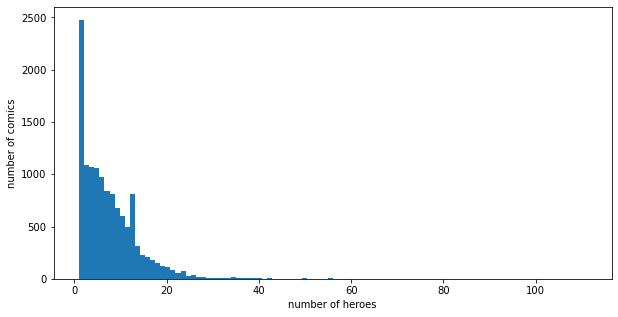

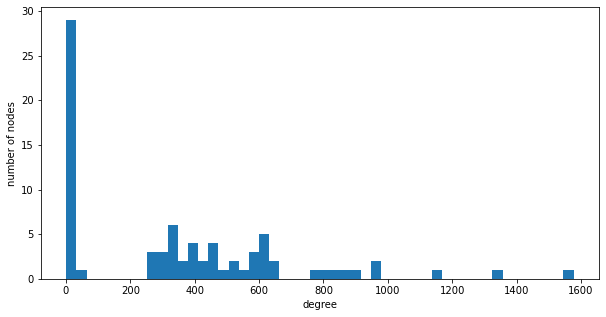

In [87]:
visualization_1(G2_topN,2,50)
# the density of the graph with the top 50 nodes is 22.62,
# the degree distribution  there are 3598 nodes with degree 1, 2022 with degree2 etc...
# the average degree is 5.97
# we ahe 324 nodes with degree more extensive than the 95th percentile of the degree distribution
# the type of the graph is SPARSE
# from the plot we cane see the number of heres that appeared in each comic, we can see that the most comics have 1 hero, around 1000 comics have 2 heroes;
# from the second plot we can see the degree distribution of the graph, we can see that the most nodes have degree 1;

### Visualization 2 - Visualize centrality measure

A table containing the information related to the requested centrality measure for:
- The average of the requested centrality measure for all of the network's nodes

In [112]:
def visualization_2(G,G_type, metric, N, node):
    G = G.copy()
    if G_type == 1:
        G = create_G1_topN(N,df_edges)
    
    def avg_centrality(G, metric):
        if metric == "betweenness":
            centrality = nx.betweenness_centrality(G)
        elif metric == "pagerank":
            centrality = nx.pagerank(G)
        elif metric == "closeness":
            centrality = nx.closeness_centrality(G)
        elif metric == "degree":
            centrality = nx.degree_centrality(G)
        else:
            print("Metric not recognized")
            return

        centrality_values = list(centrality.values())
        avg_centrality = sum(centrality_values) / len(centrality_values)
        return avg_centrality

    def functionality_2(G, node, metric, N):
        if metric == "betweenness":
            centrality = nx.betweenness_centrality(G)
        elif metric == "pagerank":
            centrality = nx.pagerank(G)
        elif metric == "closeness":
            centrality = nx.closeness_centrality(G)
        elif metric == "degree":
            centrality = nx.degree_centrality(G)
        else:
            print("Metric not recognized")
            return

        centrality_values = list(centrality.values())
        avg_centrality = sum(centrality_values) / len(centrality_values)

        # Create a dataframe with the average centrality for the specified node
        data = {node: avg_centrality}
        df = pd.DataFrame.from_dict(data, orient='index', columns=['Average ' + metric + ' centrality'])

        return df

    avg_centrality = avg_centrality(G, metric)
    print("Average " + metric + " centrality of the graph: ", avg_centrality)

    df = functionality_2(G, node, metric, N)
    return df






In [114]:
G = G1_topN  # or any other type of graph
G_type = 1
metric = "betweenness"  # or "pagerank", "closeness", or "degree"
N = 10  # number of nodes to consider
node = "node1"  # the node for which to calculate the average centrality

df = visualization_2(G, G_type, metric, N, node)

Average betweenness centrality of the graph:  0.0


In [99]:
def create_centrality_table(G, metric):
    # Calcola la centralità richiesta per ogni nodo del grafo
    if metric == "betweenness":
        centrality = nx.betweenness_centrality(G)
    elif metric == "pagerank":
        centrality = nx.pagerank(G)
    elif metric == "closeness":
        centrality = nx.closeness_centrality(G)
    elif metric == "degree":
        centrality = nx.degree_centrality(G)
    else:
        print("Metric not recognized")
        return

    # Calcola la media della centralità per tutti i nodi del grafo
    centrality_values = list(centrality.values())
    avg_centrality = sum(centrality_values) / len(centrality_values)

    # Crea una tabella con la media della centralità per ogni nodo del grafo
    data = {node: avg_centrality for node in G.nodes()}
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Average ' + metric + ' centrality'])

    return df


In [100]:
create_centrality_table(G1_topN, "closeness")

,Average closeness centrality
BLACK PANTHER/T'CHAL,0.976725
IRON MAN/TONY STARK,0.976725
THOR/DR. DONALD BLAK,0.976725
"JARVIS, EDWIN",0.976725
CYCLOPS/SCOTT SUMMER,0.976725
BEAST/HENRY &HANK& P,0.976725
HULK/DR. ROBERT BRUC,0.976725
PUNISHER II/FRANK CA,0.976725
INVISIBLE WOMAN/SUE,0.976725
THING/BENJAMIN J. GR,0.976725


In [259]:
def create_centrality_table(G, metric):
    # Calcola la centralità richiesta per ogni nodo del grafo
    if metric == "betweenness":
        centrality = nx.betweenness_centrality(G)
    elif metric == "pagerank":
        centrality = nx.pagerank(G)
    elif metric == "closeness":
        centrality = nx.closeness_centrality(G)
    elif metric == "degree":
        centrality = nx.degree_centrality(G)
    else:
        print("Metric not recognized")
        return

    # Print out the centrality values for each node
    print(centrality)

    # Calcola la media della centralità per tutti i nodi del grafo
    centrality_values = list(centrality.values())
    avg_centrality = sum(centrality_values) / len(centrality_values)

    # Crea una tabella con la media della centralità per ogni nodo del grafo
    data = {node: centrality[node] for node in G.nodes()}
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Average ' + metric + ' centrality'])

    return df


In [262]:
create_centrality_table(G1_topN, "pagerank")

{"BLACK PANTHER/T'CHAL": 0.020324003993078894, 'IRON MAN/TONY STARK': 0.011146991922261292, 'THOR/DR. DONALD BLAK': 0.009110313806244672, 'JARVIS, EDWIN': 0.01823586370410428, 'CYCLOPS/SCOTT SUMMER': 0.015518177705807525, 'BEAST/HENRY &HANK& P': 0.013159800102602896, 'HULK/DR. ROBERT BRUC': 0.012731423488367208, 'PUNISHER II/FRANK CA': 0.04404272681676919, 'INVISIBLE WOMAN/SUE': 0.010171165616320591, 'THING/BENJAMIN J. GR': 0.009649778403277031, 'SCARLET WITCH/WANDA': 0.011478957213191903, 'CAPTAIN AMERICA': 0.006939357202261385, 'WONDER MAN/SIMON WIL': 0.01938977663775758, 'WOLVERINE/LOGAN': 0.011978270326485466, 'SHE-HULK/JENNIFER WA': 0.01491251309981846, 'SILVER SURFER/NORRIN': 0.02486435588897175, 'VISION': 0.012166986273948122, 'MARVEL GIRL/JEAN GRE': 0.01732956692015042, 'STORM/ORORO MUNROE S': 0.016666787462100808, 'MR. FANTASTIC/REED R': 0.00925518502060519, 'ANGEL/WARREN KENNETH': 0.014220668427409888, 'ICEMAN/ROBERT BOBBY': 0.017418557078143458, 'HAWK': 0.015580698916741822,

,Average pagerank centrality
BLACK PANTHER/T'CHAL,0.020324
IRON MAN/TONY STARK,0.011147
THOR/DR. DONALD BLAK,0.009110
"JARVIS, EDWIN",0.018236
CYCLOPS/SCOTT SUMMER,0.015518
BEAST/HENRY &HANK& P,0.013160
HULK/DR. ROBERT BRUC,0.012731
PUNISHER II/FRANK CA,0.044043
INVISIBLE WOMAN/SUE,0.010171
THING/BENJAMIN J. GR,0.009650
